 # Telecom Churn: Pre-processing and Modeling

## Imports

In [12]:
import pickle
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from mizani.formatters import * # this has various scales
from plotnine import *
import plotnine

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, precision_recall_curve, auc
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import warnings

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

plotnine.options.figure_size = (20, 10)
warnings.filterwarnings("ignore")

## Load Data

In [13]:
telecom_df = pickle.load(open("data_clean/telecom_data.pkl", "rb"))
telecom_df.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,...,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn,set
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,...,16.78,244.7,91,11.01,10.0,3,2.70,1,False,train
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,...,16.62,254.4,103,11.45,13.7,3,3.70,1,False,train
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,...,10.30,162.6,104,7.32,12.2,5,3.29,0,False,train
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,...,5.26,196.9,89,8.86,6.6,7,1.78,2,False,train
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,...,12.61,186.9,121,8.41,10.1,3,2.73,3,False,train


# Pre-processing

## Minutes and Charge

In the Exploration Phase it was discovered the each of the *minutes* inptutes were perfectly correlated with the *charge* inputs as seen in the plot below. This also causes both minutes and charge inputs to have the same correlation with *churn*. Therefore, it is not neccessary to include both inputes as they give the same information. So the churn inputs will be removed from the dataset

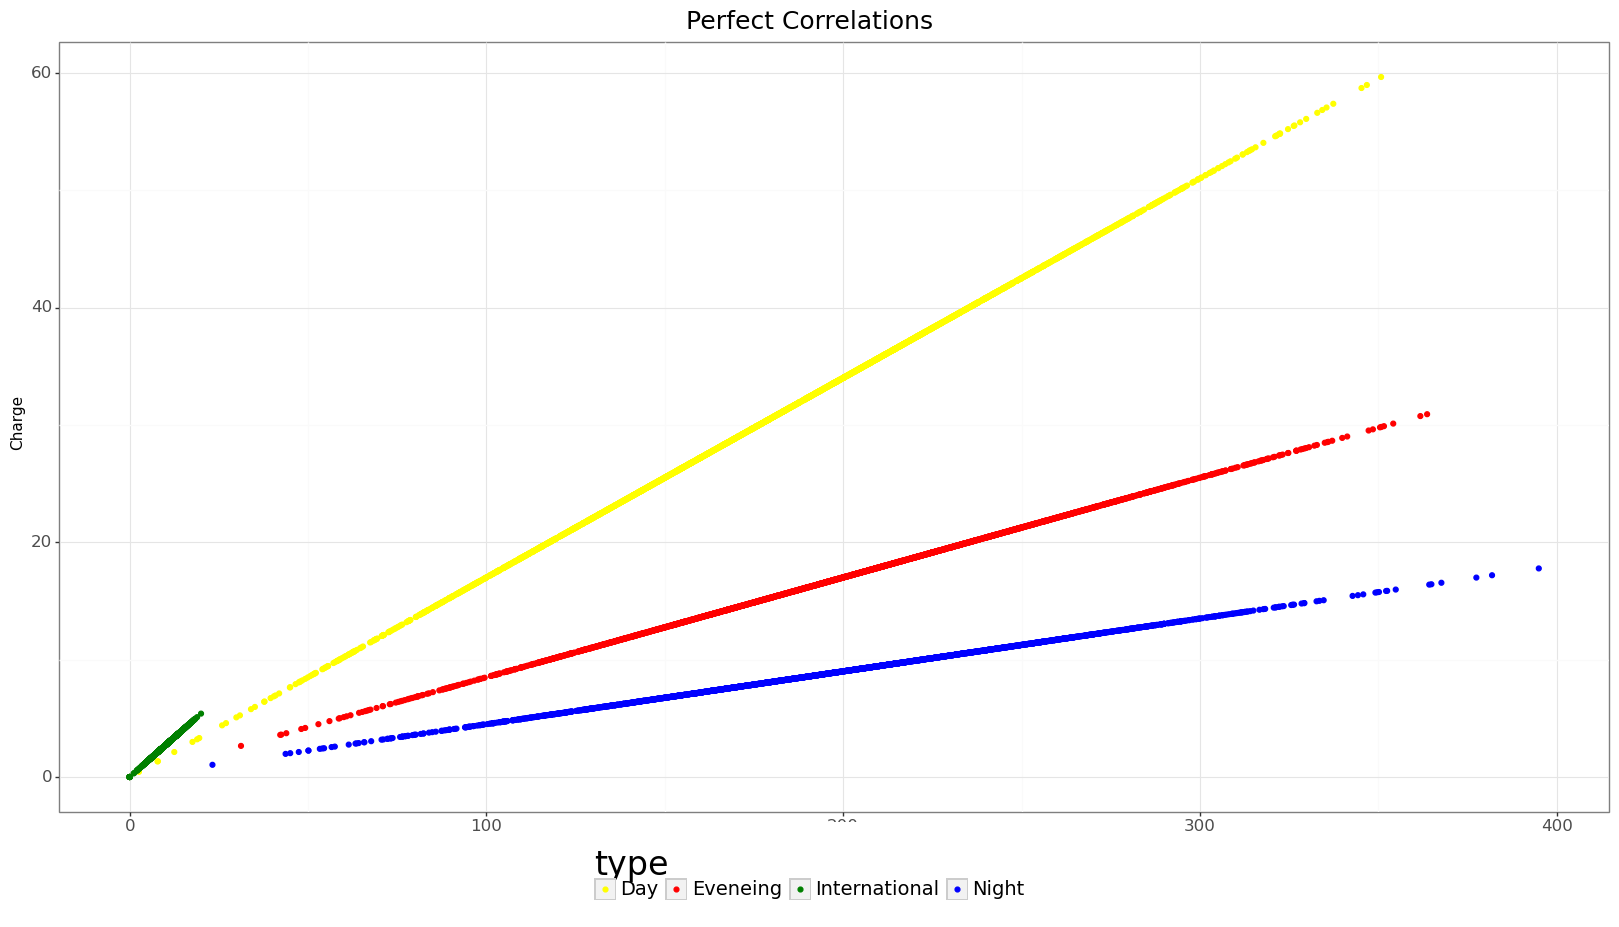

<ggplot: (123396574422)>

In [14]:
min_charge_df = pd.concat([pd.DataFrame({"type": "Day",
                                         "minutes": telecom_df.total_day_minutes,
                                         "charge": telecom_df.total_day_charge}), 
                           pd.DataFrame({"type": "Eveneing",
                                         "minutes": telecom_df.total_eve_minutes,
                                         "charge": telecom_df.total_eve_charge}), 
                           pd.DataFrame({"type": "Night",
                                         "minutes": telecom_df.total_night_minutes,
                                         "charge": telecom_df.total_night_charge}), 
                           pd.DataFrame({"type": "International",
                                         "minutes": telecom_df.total_intl_minutes,
                                         "charge": telecom_df.total_intl_charge})])

(ggplot(min_charge_df, aes(x = "minutes", y = "charge", color = "type")) + 
 geom_point() + 
 scale_color_manual(values = {"Day": "yellow", "Eveneing": "red", 
                             "Night": "blue", "International": "green"}) + 
 labs(title = "Perfect Correlations", 
      x = "Minutes", 
      y = "Charge", 
      fill = "Churn") + 
 theme_bw() + 
 theme(axis_text = element_text(size = 12), 
       legend_position = "bottom", 
       legend_text = element_text(size = 14), 
       legend_title = element_text(size = 24), 
       plot_title = element_text(size = 18)))

In [15]:
telecom_df = telecom_df.drop(columns = ["total_day_charge", "total_eve_charge", "total_night_charge", "total_intl_charge"])

## State
I'm not sure what to make of the **state** variable as it it doesnt line up with area code at all. I'm just going to remove it

In [16]:
telecom_df = telecom_df.drop(columns = ["state"])

## Dummy Variables

The **area_code** variable needs to be converted to dummy variables. There are only 3 so it won't get out of hand. 408 = San Jose, 415 = San Fransico, and 510 = East Bay.

In [17]:
telecom_df = telecom_df.assign(area_code = lambda x: x.area_code.replace({"408": "San Jose", 
                                                                          "415": "San Francisco", 
                                                                          "510": "East Bay"}))

telecom_df = pd.get_dummies(telecom_df, columns = ["area_code"], drop_first = False)

telecom_df

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,customer_service_calls,churn,set,area_code_East Bay,area_code_San Francisco,area_code_San Jose
0,128,No,Yes,25,265.1,110,197.4,99,244.7,91,10.0,3,1,False,train,0,1,0
1,107,No,Yes,26,161.6,123,195.5,103,254.4,103,13.7,3,1,False,train,0,1,0
2,137,No,No,0,243.4,114,121.2,110,162.6,104,12.2,5,0,False,train,0,1,0
3,84,Yes,No,0,299.4,71,61.9,88,196.9,89,6.6,7,2,False,train,0,0,1
4,75,Yes,No,0,166.7,113,148.3,122,186.9,121,10.1,3,3,False,train,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662,114,No,Yes,26,137.1,88,155.7,125,247.6,94,11.5,7,2,False,test,0,1,0
663,106,No,Yes,29,83.6,131,203.9,131,229.5,73,8.1,3,1,False,test,0,0,1
664,60,No,No,0,193.9,118,85.0,110,210.1,134,13.2,8,3,False,test,0,1,0
665,159,No,No,0,169.8,114,197.7,105,193.7,82,11.6,4,1,False,test,0,1,0


## International Plan and Voice Mail Plan
I'm just going to convert these yes/no variables to 1/0 numeric variables

In [18]:
telecom_df = telecom_df.assign(international_plan = lambda x: x.international_plan.replace({"Yes": "1", "No": "0"}), 
                               voice_mail_plan = lambda x: x.voice_mail_plan.replace({"Yes": "1", "No": "0"}))

telecom_df

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,customer_service_calls,churn,set,area_code_East Bay,area_code_San Francisco,area_code_San Jose
0,128,0,1,25,265.1,110,197.4,99,244.7,91,10.0,3,1,False,train,0,1,0
1,107,0,1,26,161.6,123,195.5,103,254.4,103,13.7,3,1,False,train,0,1,0
2,137,0,0,0,243.4,114,121.2,110,162.6,104,12.2,5,0,False,train,0,1,0
3,84,1,0,0,299.4,71,61.9,88,196.9,89,6.6,7,2,False,train,0,0,1
4,75,1,0,0,166.7,113,148.3,122,186.9,121,10.1,3,3,False,train,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662,114,0,1,26,137.1,88,155.7,125,247.6,94,11.5,7,2,False,test,0,1,0
663,106,0,1,29,83.6,131,203.9,131,229.5,73,8.1,3,1,False,test,0,0,1
664,60,0,0,0,193.9,118,85.0,110,210.1,134,13.2,8,3,False,test,0,1,0
665,159,0,0,0,169.8,114,197.7,105,193.7,82,11.6,4,1,False,test,0,1,0


## Churn
Lastly I want to change the churn variable from True/False to Churn/Retained for clarity

In [19]:
telecom_df = telecom_df.assign(churn = lambda x: x.churn.astype(str).replace({"True": "Churn", "False": "Retained"}))

telecom_df

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,customer_service_calls,churn,set,area_code_East Bay,area_code_San Francisco,area_code_San Jose
0,128,0,1,25,265.1,110,197.4,99,244.7,91,10.0,3,1,Retained,train,0,1,0
1,107,0,1,26,161.6,123,195.5,103,254.4,103,13.7,3,1,Retained,train,0,1,0
2,137,0,0,0,243.4,114,121.2,110,162.6,104,12.2,5,0,Retained,train,0,1,0
3,84,1,0,0,299.4,71,61.9,88,196.9,89,6.6,7,2,Retained,train,0,0,1
4,75,1,0,0,166.7,113,148.3,122,186.9,121,10.1,3,3,Retained,train,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662,114,0,1,26,137.1,88,155.7,125,247.6,94,11.5,7,2,Retained,test,0,1,0
663,106,0,1,29,83.6,131,203.9,131,229.5,73,8.1,3,1,Retained,test,0,0,1
664,60,0,0,0,193.9,118,85.0,110,210.1,134,13.2,8,3,Retained,test,0,1,0
665,159,0,0,0,169.8,114,197.7,105,193.7,82,11.6,4,1,Retained,test,0,1,0


## Training & Test Set Split
The data already came in a train and test set so instead of using *train_test_split()*, I will split the data as originally intended

In [20]:
X_train = telecom_df.query("set == 'train'").drop(columns = ["set", "churn"])
X_test = telecom_df.query("set == 'test'").drop(columns = ["set", "churn"])
y_train = telecom_df.query("set == 'train'").churn
y_test = telecom_df.query("set == 'test'").churn

## Standard Scaler

In [21]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns = X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

## Checking Train/Test Split

In [22]:
print(X_train_scaled.info(verbose = True))
print("======================================================")
print(y_train.info(verbose = True))
print("======================================================")
print(X_test_scaled.info(verbose = True))
print("======================================================")
print(y_test.info(verbose = True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   account_length           2666 non-null   float64
 1   international_plan       2666 non-null   float64
 2   voice_mail_plan          2666 non-null   float64
 3   number_vmail_messages    2666 non-null   float64
 4   total_day_minutes        2666 non-null   float64
 5   total_day_calls          2666 non-null   float64
 6   total_eve_minutes        2666 non-null   float64
 7   total_eve_calls          2666 non-null   float64
 8   total_night_minutes      2666 non-null   float64
 9   total_night_calls        2666 non-null   float64
 10  total_intl_minutes       2666 non-null   float64
 11  total_intl_calls         2666 non-null   float64
 12  customer_service_calls   2666 non-null   float64
 13  area_code_East Bay       2666 non-null   float64
 14  area_code_San Francisco 

# Modeling

## Model 1: Logistic Regression

This is a a classification problem with two possible values (Churn/Retained) which is perfect for Logistic Regression

### Hyperparameter Tuning

In [23]:
log_reg = LogisticRegression(random_state = 610)

param_grid = {"solver": ["liblinear", "sag", "saga"], 
              "C": np.arange(0.5, 5.1, 0.1), 
              "max_iter": np.arange(100, 600, 100)}

grid = GridSearchCV(log_reg, param_grid, cv = 5)

grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=610),
             param_grid={'C': array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7,
       1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. ,
       3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3,
       4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. ]),
                         'max_iter': array([100, 200, 300, 400, 500]),
                         'solver': ['liblinear', 'sag', 'saga']})

### Model Creation

In [24]:
# Logistic Regression does not have a top_featurers attribute so I made one manually
# https://stackoverflow.com/questions/34052115/how-to-find-the-importance-of-the-features-for-a-logistic-regression-model
# https://stackoverflow.com/questions/24255723/sklearn-logistic-regression-important-features

log_reg = LogisticRegression(solver = grid.best_estimator_.solver, 
                             max_iter = grid.best_estimator_.max_iter, 
                             C = grid.best_estimator_.C, 
                             random_state = 610)

log_reg.fit(X_train_scaled, y_train)

log_reg_feature_list = np.abs(np.std(X_train_scaled) * log_reg.coef_[0]).sort_values(ascending = False) 
log_reg_top_features = list(log_reg_feature_list[0:3].index)

log_reg_feature_list

voice_mail_plan            0.752632
total_day_minutes          0.675867
customer_service_calls     0.659604
international_plan         0.628734
number_vmail_messages      0.363129
total_intl_calls           0.290933
total_eve_minutes          0.285014
total_intl_minutes         0.276389
total_night_minutes        0.140860
total_day_calls            0.056701
total_night_calls          0.037651
account_length             0.034035
area_code_East Bay         0.018302
total_eve_calls            0.016230
area_code_San Jose         0.008847
area_code_San Francisco    0.008278
dtype: float64

### Model Evaluation

In [25]:
cv = KFold(n_splits = 10, random_state = 610, shuffle = True)
scores = cross_val_score(log_reg, X_train_scaled, y_train, cv = cv)
print("Cross Validation Mean Score: ", round(np.mean(scores), 4), " (Std: ", round(np.std(scores), 4), ")", sep = "")
print("Classification Report for Test Data")
print(classification_report(y_test, log_reg.predict(X_test_scaled)))

Cross Validation Mean Score: 0.8604 (Std: 0.0243)
Classification Report for Test Data
              precision    recall  f1-score   support

       Churn       0.46      0.18      0.26        95
    Retained       0.88      0.97      0.92       572

    accuracy                           0.85       667
   macro avg       0.67      0.57      0.59       667
weighted avg       0.82      0.85      0.82       667



In [26]:
evaluation_metrics = pd.array(["model", "top_features", "train_cv_mean", "train_cv_std", "accuracy", "precision", "recall", "f1"])

log_reg_evaluation = pd.array(["Logistic Regression", 
                               log_reg_top_features,
                               round(np.mean(scores), 4), 
                               round(np.std(scores), 4), 
                               round(accuracy_score(log_reg.predict(X_test_scaled), y_test), 4), 
                               round(precision_score(log_reg.predict(X_test_scaled), y_test, pos_label = "Churn"), 4), 
                               round(recall_score(log_reg.predict(X_test_scaled), y_test, pos_label = "Churn"), 4), 
                               round(f1_score(log_reg.predict(X_test_scaled), y_test, pos_label = "Churn"), 4)])

log_reg_evaluation = pd.DataFrame(log_reg_evaluation, evaluation_metrics).transpose()
log_reg_evaluation

,model,top_features,train_cv_mean,train_cv_std,accuracy,precision,recall,f1
0,Logistic Regression,"[voice_mail_plan, total_day_minutes, customer_...",0.8604,0.0243,0.8531,0.1789,0.4595,0.2576


## Model 2: Decision Tree

Continuing down the list of classification model with a Decision Tree

### Hyperparameter Tuning

In [27]:
dec_tree = DecisionTreeClassifier(random_state = 610)

param_grid = {"criterion": ["gini", "entropy", "log_loss"], 
              "max_depth": np.append(np.arange(10, 110, 10), None)}

grid = GridSearchCV(dec_tree, param_grid, cv = 5)

grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=610),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], dtype=object)})

### Model Creation

In [28]:
dec_tree = DecisionTreeClassifier(criterion = grid.best_estimator_.criterion, 
                                  max_depth = grid.best_estimator_.max_depth, 
                                  random_state = 610)

dec_tree.fit(X_train_scaled, y_train)

dec_tree_feature_list = pd.Series(dec_tree.feature_importances_, index = dec_tree.feature_names_in_).sort_values(ascending = False) 
dec_tree_top_features = list(dec_tree_feature_list[0:3].index)

dec_tree_feature_list

total_day_minutes          0.283663
total_eve_minutes          0.134532
international_plan         0.121265
total_intl_minutes         0.110326
customer_service_calls     0.106193
total_night_minutes        0.074254
total_intl_calls           0.073486
voice_mail_plan            0.037896
total_night_calls          0.016287
total_day_calls            0.014600
account_length             0.012145
number_vmail_messages      0.009579
total_eve_calls            0.005774
area_code_East Bay         0.000000
area_code_San Francisco    0.000000
area_code_San Jose         0.000000
dtype: float64

### Model Evaluation

In [29]:
cv = KFold(n_splits = 10, random_state = 610, shuffle = True)
scores = cross_val_score(dec_tree, X_train_scaled, y_train, cv = cv)
print("Cross Validation Mean Score: ", round(np.mean(scores), 4), " (Std: ", round(np.std(scores), 4), ")", sep = "")
print("Classification Report for Test Data")
print(classification_report(y_test, dec_tree.predict(X_test_scaled)))

Cross Validation Mean Score: 0.9355 (Std: 0.0084)
Classification Report for Test Data
              precision    recall  f1-score   support

       Churn       0.72      0.76      0.74        95
    Retained       0.96      0.95      0.96       572

    accuracy                           0.92       667
   macro avg       0.84      0.85      0.85       667
weighted avg       0.93      0.92      0.92       667



In [30]:
evaluation_metrics = pd.array(["model", "top_features", "train_cv_mean", "train_cv_std", "accuracy", "precision", "recall", "f1"])

dec_tree_evaluation = pd.array(["Decision Tree", 
                               dec_tree_top_features,
                               round(np.mean(scores), 4), 
                               round(np.std(scores), 4), 
                               round(accuracy_score(dec_tree.predict(X_test_scaled), y_test), 4), 
                               round(precision_score(dec_tree.predict(X_test_scaled), y_test, pos_label = "Churn"), 4), 
                               round(recall_score(dec_tree.predict(X_test_scaled), y_test, pos_label = "Churn"), 4), 
                               round(f1_score(dec_tree.predict(X_test_scaled), y_test, pos_label = "Churn"), 4)])

dec_tree_evaluation = pd.DataFrame(dec_tree_evaluation, evaluation_metrics).transpose()
dec_tree_evaluation

,model,top_features,train_cv_mean,train_cv_std,accuracy,precision,recall,f1
0,Decision Tree,"[total_day_minutes, total_eve_minutes, interna...",0.9355,0.0084,0.9235,0.7579,0.72,0.7385


## Model 3: Random Forest

Now I'll try a Random Forest. Fortunately, this dataset isn't too large so the hyperparameter tuning shouldn't take too long.

### Hyperparameter Tuning

In [31]:
rand_for = RandomForestClassifier(n_jobs = -1, random_state = 610)

param_grid = {"n_estimators": np.arange(100, 600, 100), 
              "criterion": ["gini", "entropy", "log_loss"],
              "criterion": ["gini"],
              "max_depth": [5, 10, 20, None],
              "bootstrap": [True, False]}

grid = GridSearchCV(rand_for, param_grid, cv = 5)

grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_jobs=-1, random_state=610),
             param_grid={'bootstrap': [True, False], 'criterion': ['gini'],
                         'max_depth': [5, 10, 20, None],
                         'n_estimators': array([100, 200, 300, 400, 500])})

### Model Creation

In [32]:
rand_for = RandomForestClassifier(n_estimators = grid.best_estimator_.n_estimators,
                                  criterion = grid.best_estimator_.criterion,
                                  max_depth = grid.best_estimator_.max_depth, 
                                  bootstrap = grid.best_estimator_.bootstrap, 
                                  n_jobs = -1, 
                                  random_state = 610)

rand_for.fit(X_train_scaled, y_train)

rand_for_feature_list = pd.Series(rand_for.feature_importances_, index = rand_for.feature_names_in_).sort_values(ascending = False) 
rand_for_top_features = list(rand_for_feature_list[0:3].index)

rand_for_feature_list

total_day_minutes          0.251561
customer_service_calls     0.123967
total_eve_minutes          0.099972
international_plan         0.099655
total_intl_minutes         0.081127
total_intl_calls           0.068415
total_night_minutes        0.056697
total_day_calls            0.042143
account_length             0.041260
total_night_calls          0.040280
total_eve_calls            0.037045
number_vmail_messages      0.024431
voice_mail_plan            0.014971
area_code_San Francisco    0.006740
area_code_San Jose         0.006200
area_code_East Bay         0.005534
dtype: float64

### Model Evaluation

In [33]:
cv = KFold(n_splits = 10, random_state = 610, shuffle = True)
scores = cross_val_score(rand_for, X_train_scaled, y_train, cv = cv)
print("Cross Validation Mean Score: ", round(np.mean(scores), 4), " (Std: ", round(np.std(scores), 4), ")", sep = "")
print("Classification Report for Test Data")
print(classification_report(y_test, rand_for.predict(X_test_scaled)))

Cross Validation Mean Score: 0.952 (Std: 0.0131)
Classification Report for Test Data
              precision    recall  f1-score   support

       Churn       0.93      0.73      0.82        95
    Retained       0.96      0.99      0.97       572

    accuracy                           0.95       667
   macro avg       0.94      0.86      0.89       667
weighted avg       0.95      0.95      0.95       667



In [34]:
evaluation_metrics = pd.array(["model", "top_features", "train_cv_mean", "train_cv_std", "accuracy", "precision", "recall", "f1"])

rand_for_evaluation = pd.array(["Random Forest", 
                               rand_for_top_features,
                               round(np.mean(scores), 4), 
                               round(np.std(scores), 4), 
                               round(accuracy_score(rand_for.predict(X_test_scaled), y_test), 4), 
                               round(precision_score(rand_for.predict(X_test_scaled), y_test, pos_label = "Churn"), 4), 
                               round(recall_score(rand_for.predict(X_test_scaled), y_test, pos_label = "Churn"), 4), 
                               round(f1_score(rand_for.predict(X_test_scaled), y_test, pos_label = "Churn"), 4)])

rand_for_evaluation = pd.DataFrame(rand_for_evaluation, evaluation_metrics).transpose()
rand_for_evaluation

,model,top_features,train_cv_mean,train_cv_std,accuracy,precision,recall,f1
0,Random Forest,"[total_day_minutes, customer_service_calls, to...",0.952,0.0131,0.9535,0.7263,0.9324,0.8166


## Model 4: K-Nearest Neighbors

Three models is probably enough, but I want to just see how K-Nearest Neighbors stacks up to the others.

In [35]:
knn = KNeighborsClassifier()

param_grid = {"n_neighbors": np.arange(1, 6)}

grid = GridSearchCV(knn, param_grid, cv = 5)

grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([1, 2, 3, 4, 5])})

In [36]:
knn = KNeighborsClassifier(n_neighbors = grid.best_estimator_.n_neighbors)

knn.fit(X_train_scaled, y_train)

#knn_feature_list = pd.Series(knn.feature_importances_, index = knn.feature_names_in_).sort_values(ascending = False) 
#knn_top_features = list(knn_feature_list[0:3].index)
#
#knn_feature_list

KNeighborsClassifier(n_neighbors=4)

In [37]:
cv = KFold(n_splits = 10, random_state = 610, shuffle = True)
scores = cross_val_score(knn, X_train_scaled, y_train, cv = cv)
print("Cross Validation Mean Score: ", round(np.mean(scores), 4), " (Std: ", round(np.std(scores), 4), ")", sep = "")
print("Classification Report for Test Data")
print(classification_report(y_test, knn.predict(X_test_scaled)))

Cross Validation Mean Score: 0.8811 (Std: 0.0157)
Classification Report for Test Data
              precision    recall  f1-score   support

       Churn       0.56      0.37      0.45        95
    Retained       0.90      0.95      0.93       572

    accuracy                           0.87       667
   macro avg       0.73      0.66      0.69       667
weighted avg       0.85      0.87      0.86       667



In [38]:
evaluation_metrics = pd.array(["model", "top_features", "train_cv_mean", "train_cv_std", "accuracy", "precision", "recall", "f1"])

knn_evaluation = pd.array(["K-Nearest Neighbors", 
                               ["NA1", "NA2", "NA3"],
                               round(np.mean(scores), 4), 
                               round(np.std(scores), 4), 
                               round(accuracy_score(knn.predict(X_test_scaled), y_test), 4), 
                               round(precision_score(knn.predict(X_test_scaled), y_test, pos_label = "Churn"), 4), 
                               round(recall_score(knn.predict(X_test_scaled), y_test, pos_label = "Churn"), 4), 
                               round(f1_score(knn.predict(X_test_scaled), y_test, pos_label = "Churn"), 4)])

knn_evaluation = pd.DataFrame(knn_evaluation, evaluation_metrics).transpose()
knn_evaluation

,model,top_features,train_cv_mean,train_cv_std,accuracy,precision,recall,f1
0,K-Nearest Neighbors,"[NA1, NA2, NA3]",0.8811,0.0157,0.8696,0.3684,0.5645,0.4459


## Model Comparison
With all the models cretaed and all the evaluation metrics completed, I will now compare them.

## Accuracy Metrics
First, I will concatenate each of the evluation metrics tables together and plot out each metric to easily compare them.

In [39]:
evaluation_df = pd.concat([log_reg_evaluation, dec_tree_evaluation, rand_for_evaluation, knn_evaluation]).\
                set_index("model").\
                sort_values("accuracy", ascending = False)

evaluation_df

,top_features,train_cv_mean,train_cv_std,accuracy,precision,recall,f1
model,,,,,,,
Random Forest,"[total_day_minutes, customer_service_calls, to...",0.952,0.0131,0.9535,0.7263,0.9324,0.8166
Decision Tree,"[total_day_minutes, total_eve_minutes, interna...",0.9355,0.0084,0.9235,0.7579,0.72,0.7385
K-Nearest Neighbors,"[NA1, NA2, NA3]",0.8811,0.0157,0.8696,0.3684,0.5645,0.4459
Logistic Regression,"[voice_mail_plan, total_day_minutes, customer_...",0.8604,0.0243,0.8531,0.1789,0.4595,0.2576


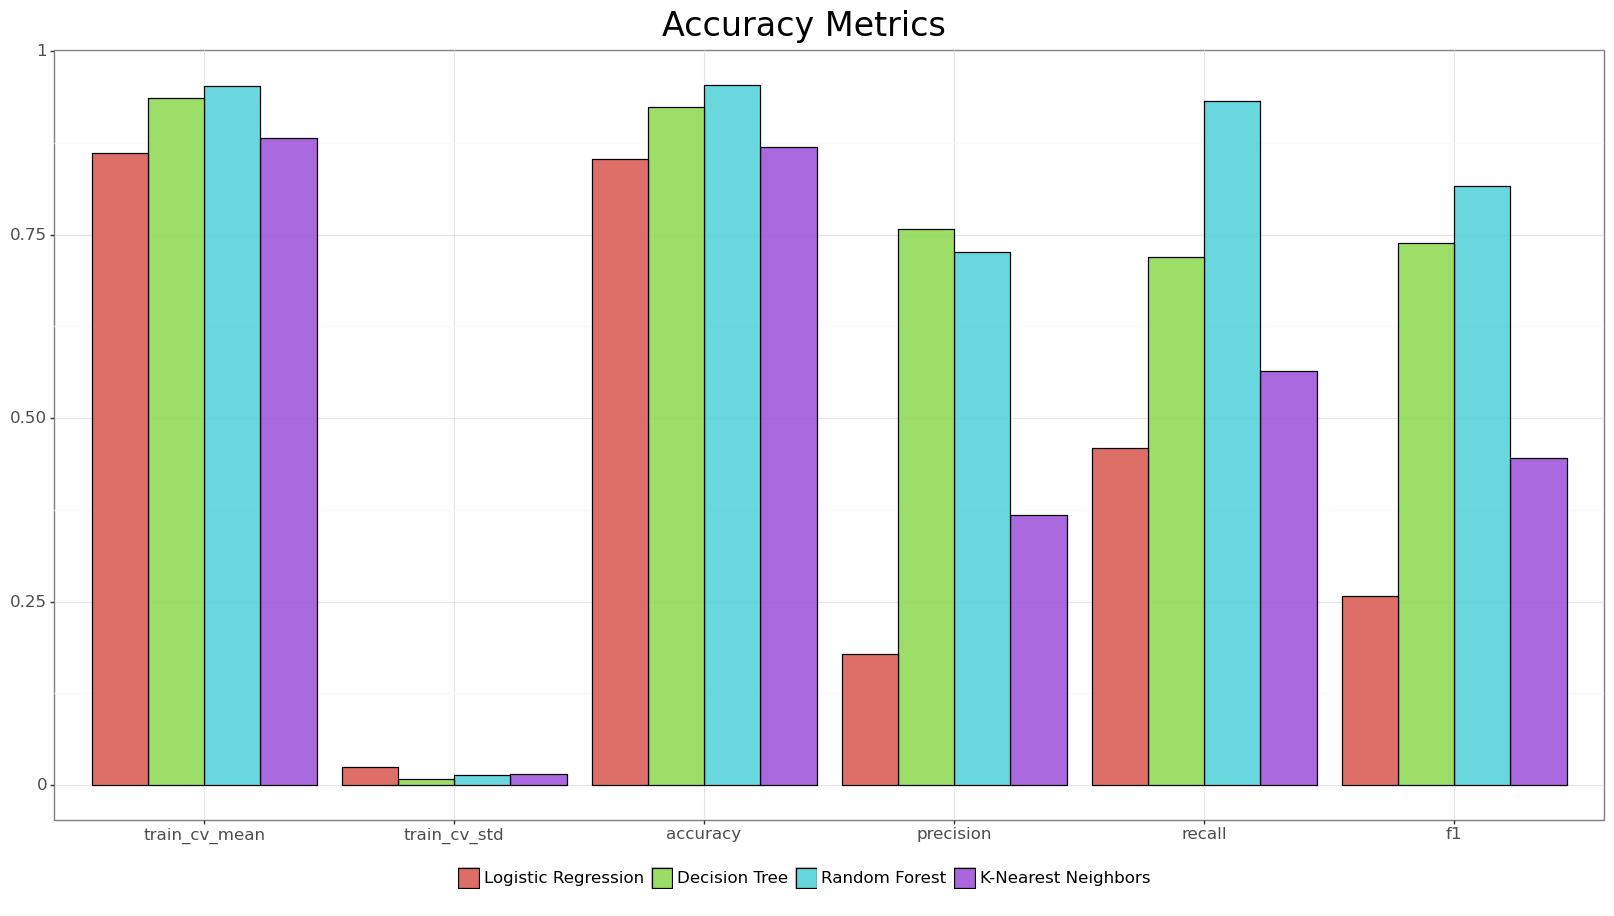

<ggplot: (149396666480)>

In [30]:
evaluation_df2 = evaluation_df.\
reset_index().\
rename(columns = {"index": "model"}).\
melt(id_vars = ["model"], 
     value_vars = ["train_cv_mean", "train_cv_std", "accuracy", "precision", "recall", "f1"], 
     var_name = "metric", 
     value_name = "score").\
assign(model = lambda x: x.model.astype("category").cat.reorder_categories(["Logistic Regression", "Decision Tree", "Random Forest", "K-Nearest Neighbors"]), 
       metric = lambda x: x.metric.astype("category").cat.reorder_categories(["train_cv_mean", "train_cv_std", "accuracy", 
                                                                              "precision", "recall", "f1"]), 
       score = lambda x: x.score.astype(float))

(ggplot(evaluation_df2, aes(x = "metric", y = "score", fill = "model")) + 
 geom_bar(stat = "identity", position = "dodge", color = "black", alpha = 0.9) + 
 scale_y_continuous() + 
 labs(title = "Accuracy Metrics", 
      x = "", 
      y = "") + 
 theme_bw() +
 theme(axis_text = element_text(size = 12), 
       legend_position = "bottom",
       legend_text = element_text(size = 12),
       legend_title = element_blank(), 
       legend_box_spacing = .3,
       plot_title = element_text(size = 24)))

Definitions for evaluation metrics
* **Accuracy:** Percent of correctly predicted classes
* **Precision:** TP / (TP + FN)
* **Recall:** TP / (TP + FN)
* **F1:** 2 * (Precision * Recall) / (Precision + Recall)

For every evaluation metric, the order from best to worst was Random Forest, Decision Tree, KNN, then Logistic Regression. The only exception si the precisionscore in which Decision Tree slightly outperformed Random Forest. Random Forest is the obvious choice here, but I'll still check other methods of evaluation to be thorough.

## Precision/Recall Curve

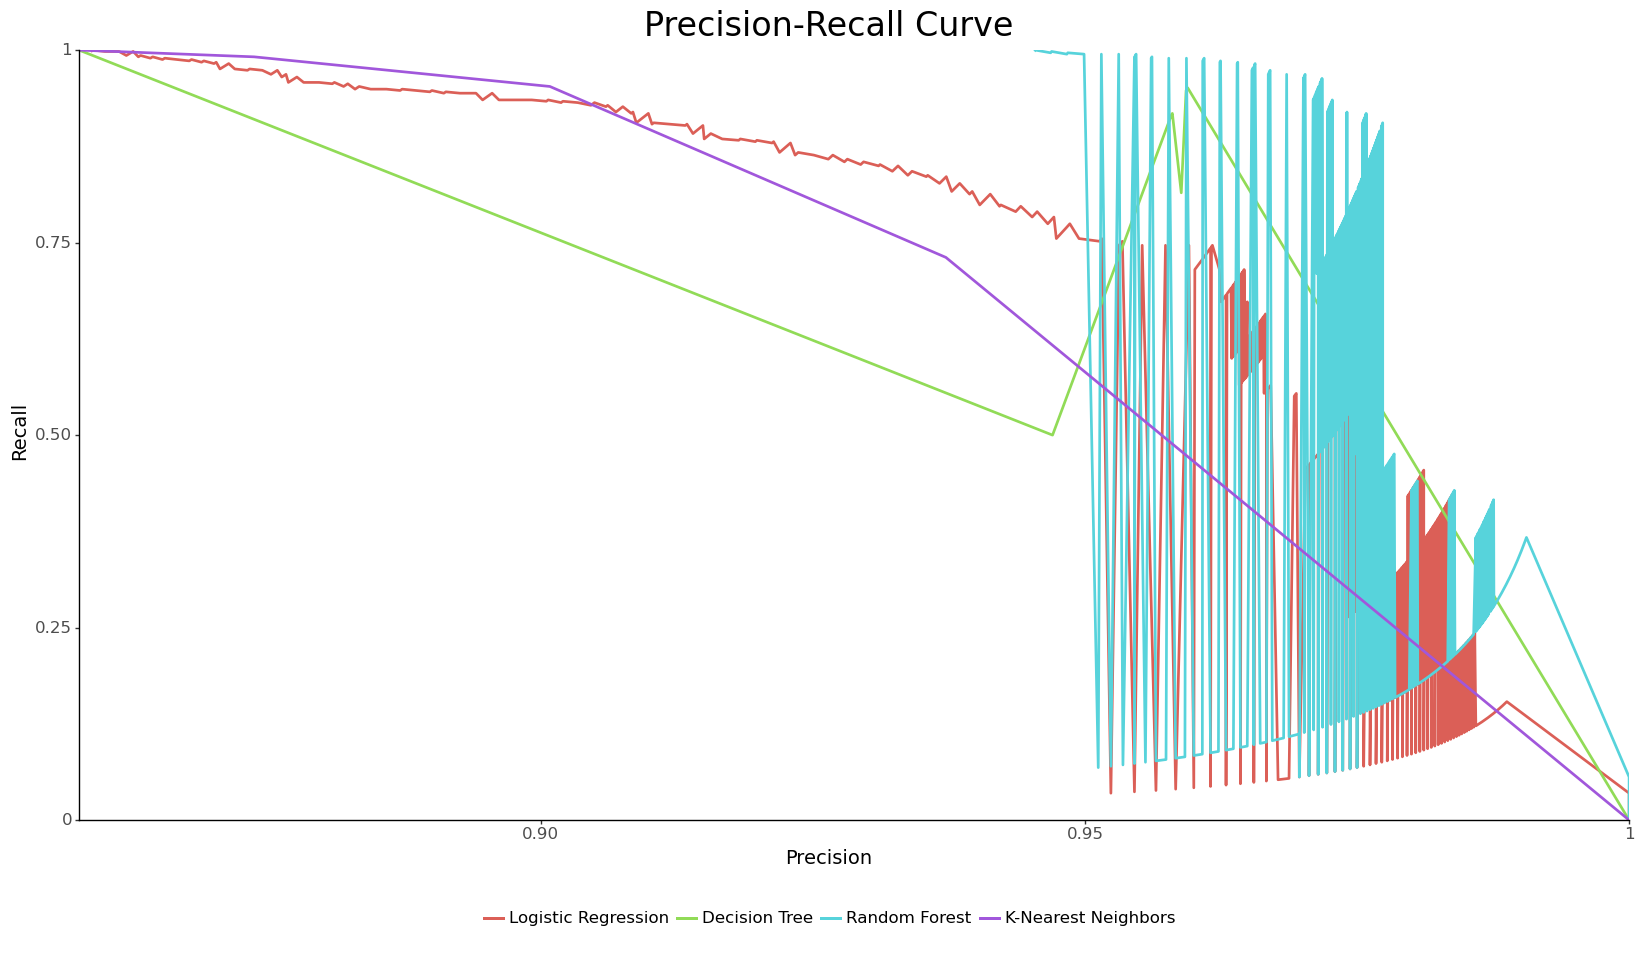

<ggplot: (123396408043)>

In [43]:
model_names = ["Logistic Regression", 
               "Decision Tree", 
               "Random Forest", 
               "K-Nearest Neighbors"]

predicted_probs = [log_reg.predict_proba(X_test_scaled)[:, 1],
                   dec_tree.predict_proba(X_test_scaled)[:, 1],
                   rand_for.predict_proba(X_test_scaled)[:, 1],
                   knn.predict_proba(X_test_scaled)[:, 1]]

pr_df = pd.DataFrame({"model": [], 
                      "precision" : [], 
                      "recall" : [],
                      "thresholds" : []})

for i in range(len(model_names)): 
    
    precision, recall, thresholds  = precision_recall_curve(y_test, predicted_probs[i], pos_label = "Retained")
    
    thresholds = np.append(thresholds, 0)
    
    pr_append_df = pd.DataFrame({"model": model_names[i], 
                                 "precision":precision, 
                                 "recall":recall, 
                                 "thresholds":thresholds})
    
    pr_df = pr_df.append(pr_append_df)
    
pr_df = pr_df.\
assign(model = lambda x: x.model.astype("category").cat.reorder_categories(["Logistic Regression", "Decision Tree", 
                                                                            "Random Forest", "K-Nearest Neighbors"]))

(ggplot(pr_df, aes(x = "precision", y = "recall", color = "model")) + 
 geom_line(size = 1.1) + 
 scale_x_continuous(expand = [0, 0]) + 
 scale_y_continuous(expand = [0, 0]) + 
 labs(title = "Precision-Recall Curve", 
      x = "Precision", 
      y = "Recall") + 
 theme_classic() +
 theme(axis_text = element_text(size = 12), 
       axis_title = element_text(size = 14),
       legend_position = "bottom",
       legend_text = element_text(size = 12),
       legend_title = element_blank(), 
       legend_box_spacing = .7,
       plot_title = element_text(size = 24)))

This curve often gets janky due to rounding of Precision & Recall values, but you can still see the general shape. Although iin this case, Random Forest looks so janky, that I'll just skip this and look at the ROC curve.

## ROC Curve

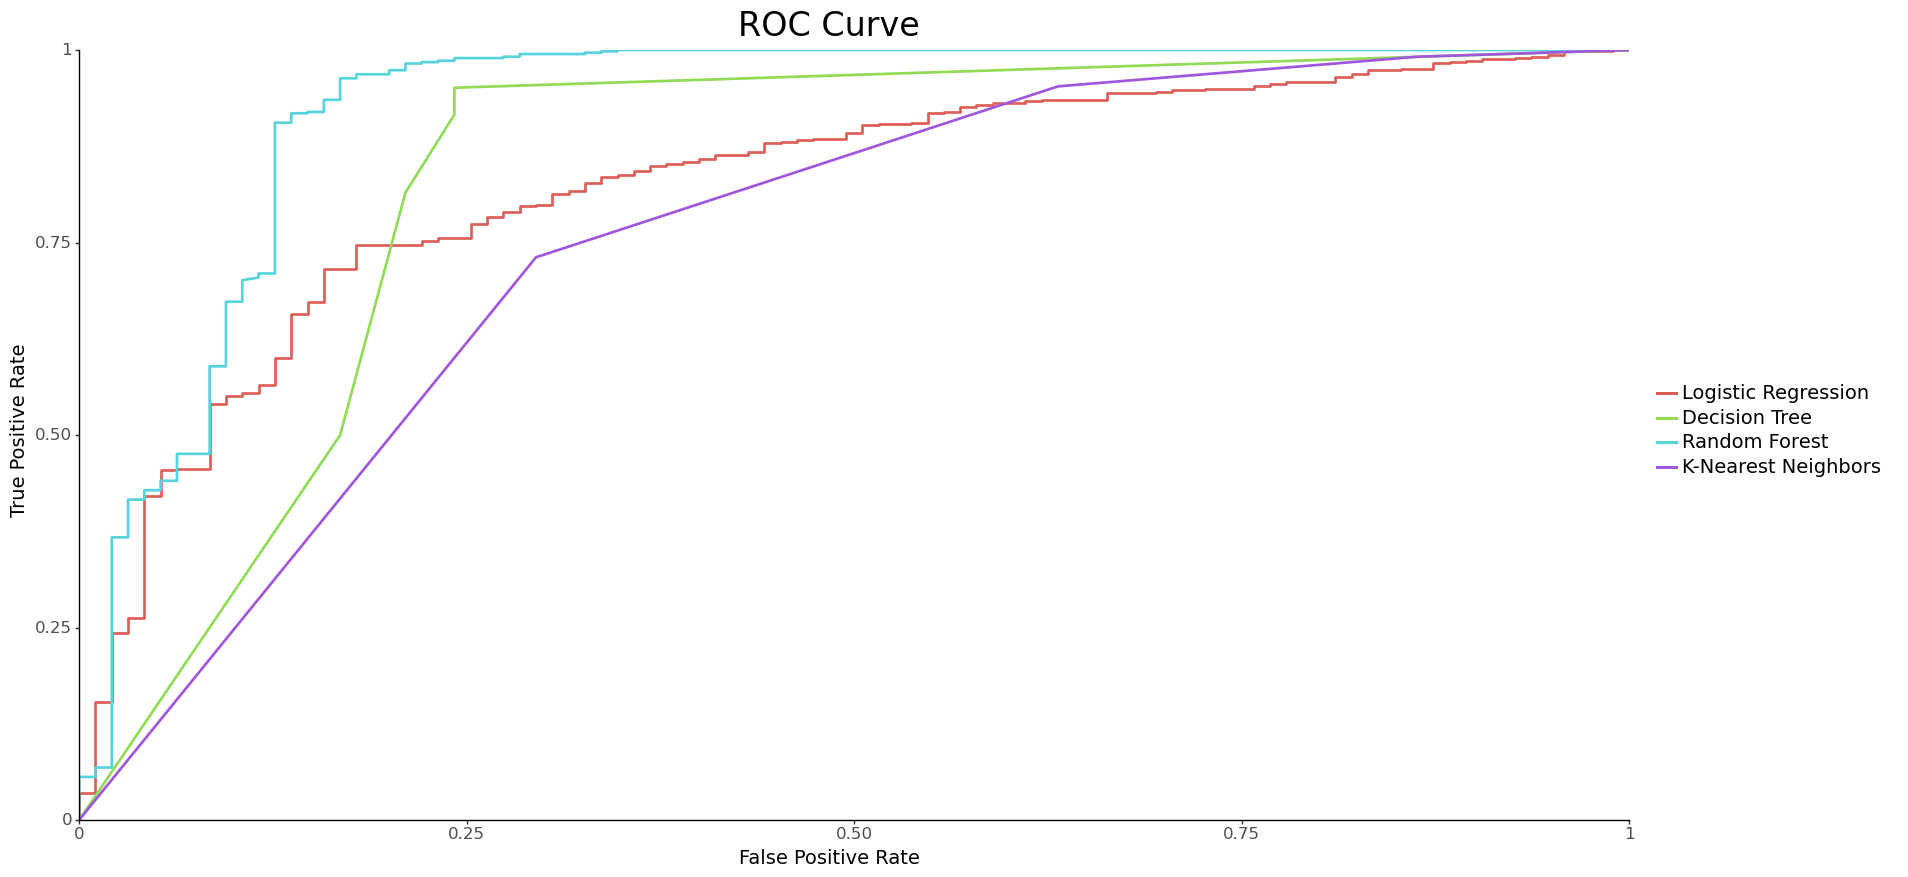


                 model    auc
0        Random Forest  0.925
0        Decision Tree  0.836
0  Logistic Regression  0.825
0  K-Nearest Neighbors  0.753


In [48]:
model_names = ["Logistic Regression", 
               "Decision Tree", 
               "Random Forest",
               "K-Nearest Neighbors"]

predicted_probs = [log_reg.predict_proba(X_test_scaled)[:, 1],
                   dec_tree.predict_proba(X_test_scaled)[:, 1],
                   rand_for.predict_proba(X_test_scaled)[:, 1],
                   knn.predict_proba(X_test_scaled)[:, 1]]

roc_df = pd.DataFrame({"model": [], 
                       "fpr" : [], 
                       "tpr" : [],
                       "thresholds" : []})

for i in range(len(model_names)): 
    
    fpr, tpr, thresholds  = roc_curve(y_test, predicted_probs[i], pos_label = "Retained")
    
    roc_append_df = pd.DataFrame({"model": model_names[i],
                                  "auc": round(auc(fpr, tpr), 3).astype(str),
                                  "fpr":fpr, 
                                  "tpr":tpr, 
                                  "thresholds":thresholds})
    
    roc_df = roc_df.append(roc_append_df)

roc_df = roc_df.\
assign(model = lambda x: x.model.astype("category").cat.reorder_categories(["Logistic Regression", "Decision Tree", 
                                                                            "Random Forest", "K-Nearest Neighbors"]))

print(ggplot(roc_df, aes(x = "fpr", y = "tpr", color = "model")) + 
 geom_line(size = 1.1) + 
 scale_x_continuous(expand = [0, 0]) + 
 scale_y_continuous(expand = [0, 0]) + 
 labs(title = "ROC Curve", 
      x = "False Positive Rate", 
      y = "True Positive Rate") + 
 theme_classic() +
 theme(axis_text = element_text(size = 12), 
       axis_title = element_text(size = 14), 
       legend_position = "right",
       legend_text = element_text(size = 14),
       legend_title = element_blank(), 
       plot_title = element_text(size = 24)))

print(roc_df.\
query("tpr == 0").\
      sort_values("auc", ascending = False)[["model", "auc"]])

Like the earlier test results, Random Forest outperformed all other models. Despite the differing shapes, Decision tree and Logistic Regression have nearly identical AUCs.

## Feature Importance
Now I will plot out the feature importances to clearly see which features were most important in building the models.

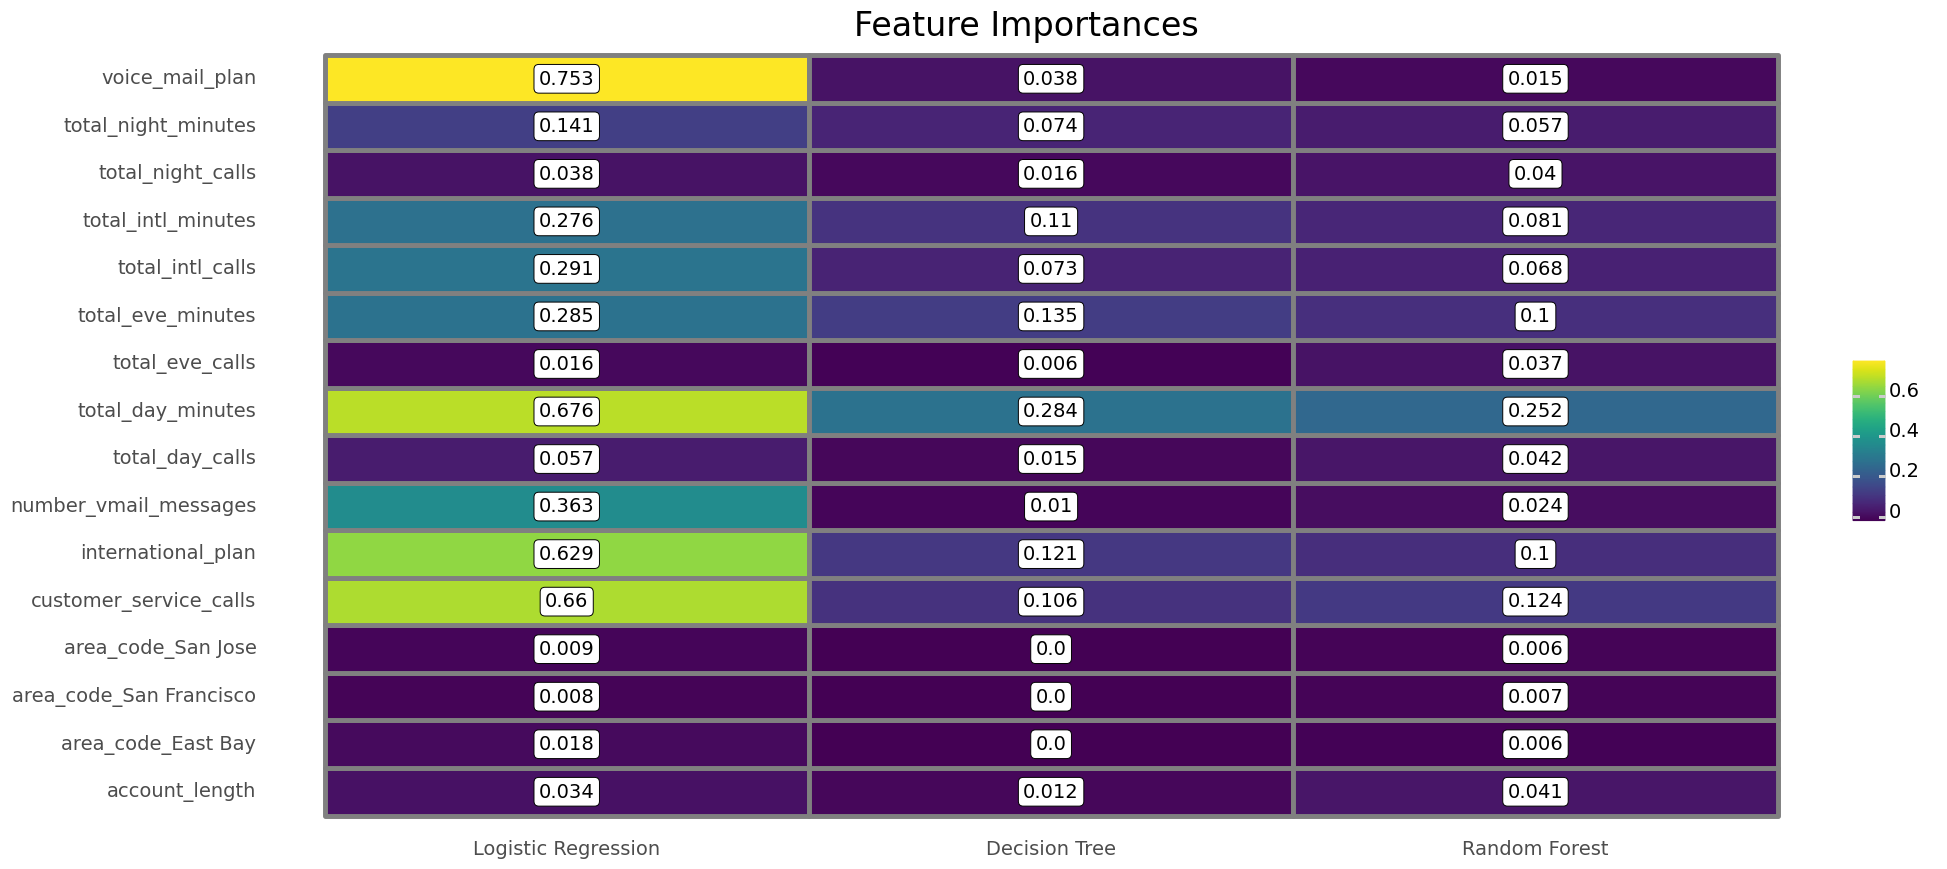

<ggplot: (123397157557)>

In [50]:
feature_list_df = pd.DataFrame({"Logistic Regression" : np.abs(np.std(X_train_scaled) * log_reg.coef_[0]).sort_values(ascending = False), 
                                "Decision Tree" : pd.Series(dec_tree.feature_importances_, index = dec_tree.feature_names_in_).sort_values(ascending = False),
                                "Random Forest" : pd.Series(rand_for.feature_importances_, index = rand_for.feature_names_in_).sort_values(ascending = False)}).reset_index().\
rename(columns = {"index" : "feature"}).\
melt(id_vars = ["feature"], 
     value_vars = ["Logistic Regression", "Decision Tree", "Random Forest"], 
     var_name = "model", 
     value_name = "importance").\
assign(lab_text = lambda x: np.round(x.importance, 3), 
       model = lambda x: x.model.astype("category").cat.reorder_categories(["Logistic Regression", "Decision Tree", "Random Forest"]))

(ggplot(feature_list_df, aes(x = "model", y = "feature", fill = "importance")) + 
 geom_tile(color = "grey", size = 2) +
 geom_label(aes(label = "lab_text"), fill = "white", size = 14) + 
 labs(title = "Feature Importances", 
      x = "", 
      y = "", 
      fill = "") + 
 theme_minimal() + 
 theme(axis_text_x = element_text(size = 14), 
       axis_text_y = element_text(size = 14), 
       legend_text = element_text(size = 14),
       panel_grid_major = element_blank(), 
       plot_title = element_text(size = 24)))

At this point, I've decided to go with the Random Forest so I'll look at those features alone

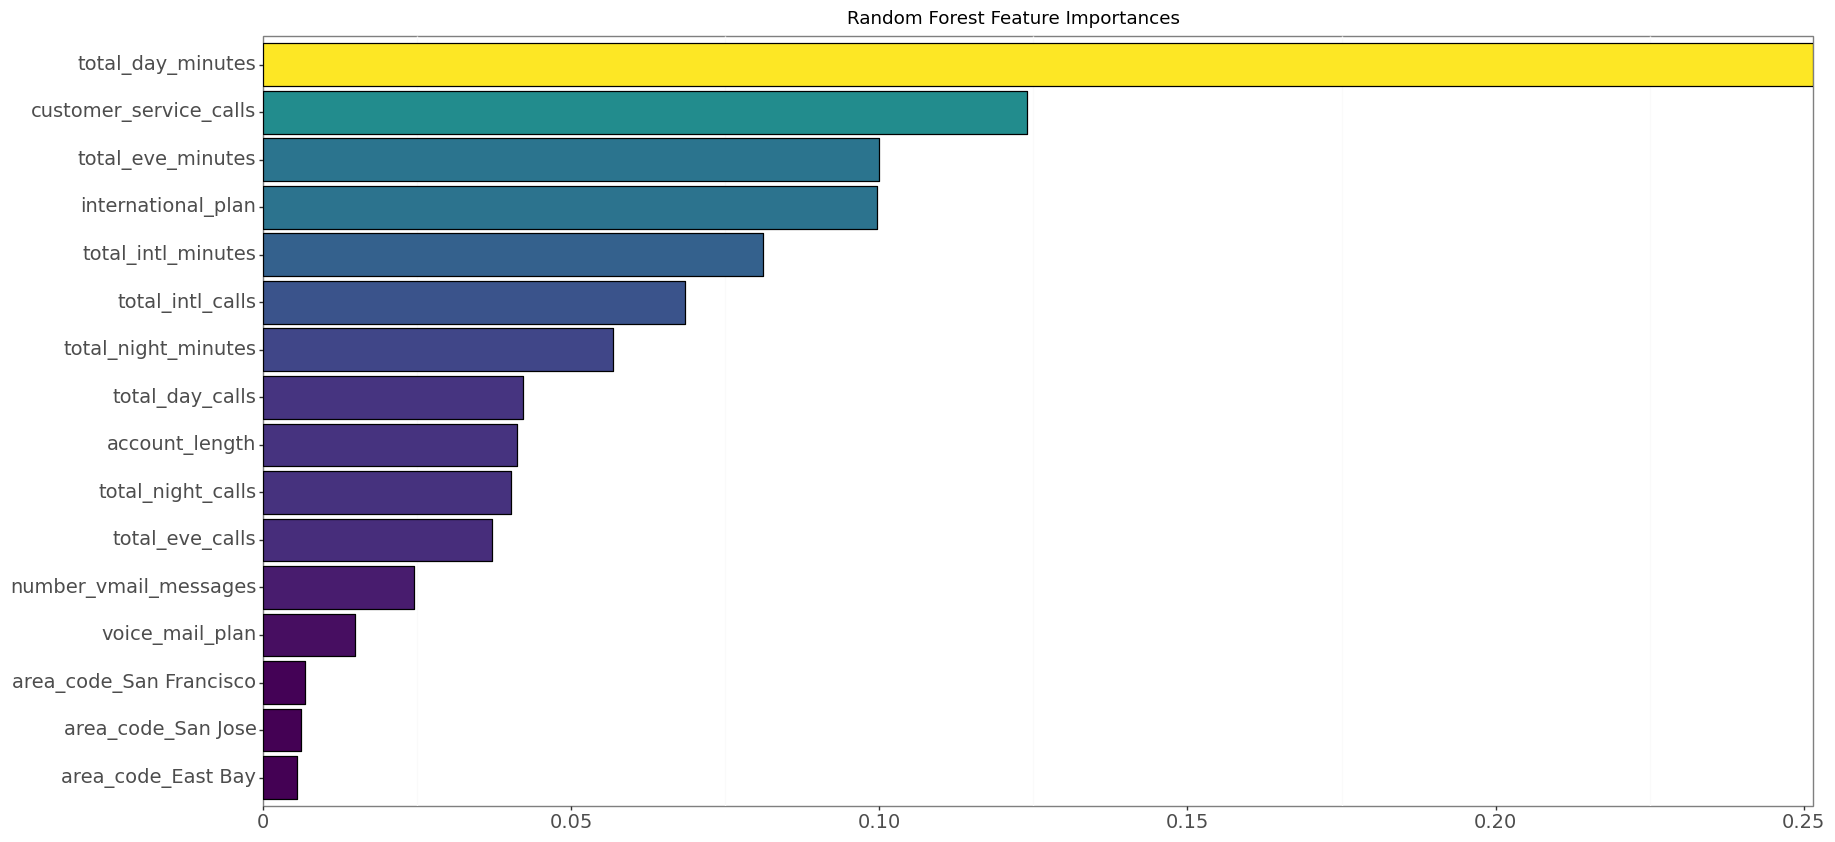

<ggplot: (123397522929)>

In [51]:
rand_for_features_df = feature_list_df.query("model == 'Random Forest'").\
assign(feature = lambda x: x.feature.astype("category").cat.reorder_categories(x.set_index("feature").sort_values("importance").index.tolist()))

(ggplot(rand_for_features_df, aes(x = "feature", y = "importance", fill = "importance")) + 
 geom_bar(stat = "identity", color = "black") + 
 coord_flip() + 
 scale_y_continuous(expand = [0, 0])+ 
 labs(title = "Random Forest Feature Importances", 
      x = "", 
      y = "", 
      fill = "") + 
 theme_bw() + 
 theme(axis_text_x = element_text(size = 14), 
       axis_text_y = element_text(size = 14), 
       legend_position = "none",
       panel_grid_major = element_blank()))

By far the most impoprtant feature is **total_day_minutes**. From there on out, the features can be grouped in tiers

* **Tier 1:** total_day_mintues 
* **Tier 2:** customer_service_calls, total_eve_minutes, international_plan
* **Tier 3:** total_intl_minutes, total_intl_calls, total_night_minutes
* **Tier 4:** total_day_calls, account_length, total_night_calls, total_eve_calls
* **Tier 5:** number_vmail_messages, voice_mail_plan, area_code_San_Francisco, area_code_San_Jose, area_code_East_bay